# Forecasting Fundamentals with Python & Facebook Prophet

## Table of Contents
- [Introduction](#intro)
- [Components of a Time Series](#comp) 
- [The Facebook Prophet Model ](#fp)
- [Forecasting Case Study](#cs)
- [Forecasting Model Evaluation ](#me)
- [Conclusion & Further References](#conc)

## Introduction <a id='intro'></a>

Forecasting is the process of making predictions into the future about a variable that changes as a function of time. It is a common task in business, economics, and other fields. Some forecasting tasks of interest are Internet traffic forecasting, uptake and churn forecasting, forecasting number of car accidents or number of houses sold, weather forecasting (rain, temperature, etc), and forecasting consumption of electricity, gas, water, petrol, etc.  

In this notebook tutorial, we provide a basic overview of time series and give examples on how to use the popular Facebook Prophet Python module for making predictions about future events.

### Stationary vs. Non-stationary Time Series

A time series is generally characterised as either *stationary* or *non-stationary*. A stationary time series does not depend on the time at which the series is recorded. That is, a stationary time series “does not go anywhere” during the period of interest. Thus, time series with trends and/ or seasonality are said to be non-stationary. On the other hand, a stationary time series can still have aperiodic cycles that are not of a fixed length, so stationary time series will have no predictable patterns in the long-term. 

**Reference:** 
- https://blog.bigml.com/2017/07/12/introduction-to-time-series/

## Components of a Time Series <a id='comp'></a>

Time Series models are characterized by the four components below:

1. **Level:** This is the value of a (stationary) time series assuming that the variable will remain constant over time.

2. **Trend:** The trend component of a (non-stationary) time series represents the long-term direction the series is moving in. The trend can be either additive (a linear change in value) or multiplicative (an exponential change). 

3. **Seasonality:** The seasonality component of a (non-stationary) time series represents any variation in its value which follows a consistent pattern over consecutive, fixed-length intervals. For example, Internet traffic load will be higher during the day and lower at nights. This variation may be modelled as a relatively constant amount independent of the time series' level (additive seasonality), or as a relatively constant proportion of the level (multiplicative seasonality). Seasonality can be on an hourly, daily, weekly, monthly, quarterly, or yearly cycle. For instance, international air travel volume has a yearly seasonality cycle (more travel during summer and less during winter). Sometimes series even have multiple seasonality, such as Internet traffic changing during the day vs. night and also changing during the weekend vs. weekday. 

4. **Error:** After accounting for the level, trend, and seasonality components, there still remains some variation not yet accounted for by the model. Like seasonality, error may be modeled as an additive process (independent of the series level), or multiplicative process (proportional to the series level). Correctly parameterizing this error component is important for estimating confidence bounds for time series forecasts.

### Three Types of Forecasting

Most forecasting tasks can be divided into three types below:

1. **Level forecasting:** This involves predicting the value of a stationary time series at a future point in time; assuming that the variable will remain constant (i.e., it will not change).

2. **Trend forecasting:** This involves predicting the future value of a variable based on past trends. This type of forecasting assumes that the variable will change over time, but at a consistent rate.

3. **Seasonality forecasting:** This involves predicting the future value of a variable based on seasonal patterns. This type of forecasting assumes that the variable will follow a regular pattern over the course of a certain time period.

To create any forecast, we will first need historical data for the model training phase (also known as model fitting) and then choose a time period in the future for the forecast called the forecast horizon (e.g., the next month, the next quarter, etc). 

## The Facebook Prophet Model <a id='fp'></a>

The Facebook Prophet model was introduced in a 2018 [publication](https://peerj.com/preprints/3190.pdf) by Taylor, S.J., & Letham, B. ("Forecasting at scale", The American Statistician). It was originally developed for forecasting daily data with weekly and yearly seasonality together with holiday effects. It works best with time series that have strong seasonality and several seasons of historical data.

Prophet can be considered a **nonlinear regression model** of the form 

$$y_t=g(t)+s(t)+h(t)+ε_t$$

where g(t) describes a piecewise-linear trend (or "growth term"), s(t) describes the various seasonal patterns, h(t) captures the holiday effects, and $ε_t$ is a white noise error term. Specifically,

- g(t) is the trend function which models non-periodic changes in the value of the time series.
- s(t) represents periodic changes (e.g., weekly and yearly seasonality).
- h(t) represents the effects of holidays which occur on potentially irregular schedules over one or more days. 
- The error term $ε_t$ represents random changes which are not accounted for by the model. It is further assumed that $ε_t$ is normally distributed.

Some further observations are as follows:
- The knots (or change points) for the piecewise-linear trend are automatically selected if not explicitly specified. Optionally, a logistic growth function can be used to set an upper bound on the trend.
- The seasonal component consists of Fourier decomposition terms of the relevant periods.
- Holiday effects can also be modeled. They are added as simple dummy variables.
- The model is estimated using a Bayesian approach to allow for automatic selection of the change points and other model characteristics.


The Facebook Prophet Python module can be installed as follows:
```Python
python -m pip install prophet
```
Facebook Prophet requires that the dates of our time series are located in a column titled `ds` and the values of the series in a column titled `y`. Note that if we are using logistic growth, we will also need to add additional cap and/ or floor columns with the maximum and minimum values of the possible growth at each specific time entry in the time series.

**References:** 
1. https://facebook.github.io/prophet/
2. https://otexts.com/fpp3/prophet.html
3. https://peerj.com/preprints/3190.pdf
4. https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a

## Forecasting Case Study <a id='cs'></a>

### Vanilla Prophet

Below is a simple example of how to create a forecast using Python and Facebook Prophet. The time series dataset we use is the log of daily number of page visits to the R (programming language) page on Wikipedia from January 2013 to June 2013.

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 300) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn")

In [3]:
# get the dataset from the cloud
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R.csv')

# sort by increasing date
df = df.sort_values(by=['ds'])

In [4]:
print(f"earliest date: {df['ds'].min()}")
print(f"latest date: {df['ds'].max()}")

earliest date: 2008-01-01
latest date: 2015-12-31


In [5]:
### apply date filter
earliest_date = '2013-01-01'
latest_date = '2013-06-30'

In [6]:
print(f"--> rows before date filter: {df.shape[0]}")
#
df = df[(df['ds'] >= earliest_date) & (df['ds'] <= latest_date)]
#
df['ds'] = pd.to_datetime(df['ds']).dt.date
#
print(f"new earliest date: {df['ds'].min()}")
print(f"new latest date: {df['ds'].max()}")
print(f"--> rows after date filter: {df.shape[0]}")

--> rows before date filter: 2863
new earliest date: 2013-01-01
new latest date: 2013-06-30
--> rows after date filter: 181


In [7]:
# head of the dataset 
df.head(5)

,ds,y
1795,2013-01-01,7.1491
1797,2013-01-02,7.8168
1796,2013-01-03,7.8823
1799,2013-01-04,7.8284
1798,2013-01-05,7.5720


In [8]:
# tail of the dataset
df.tail(5)

,ds,y
1951,2013-06-26,7.6903
1952,2013-06-27,7.7003
1953,2013-06-28,7.4955
1924,2013-06-29,7.0741
1933,2013-06-30,7.1285


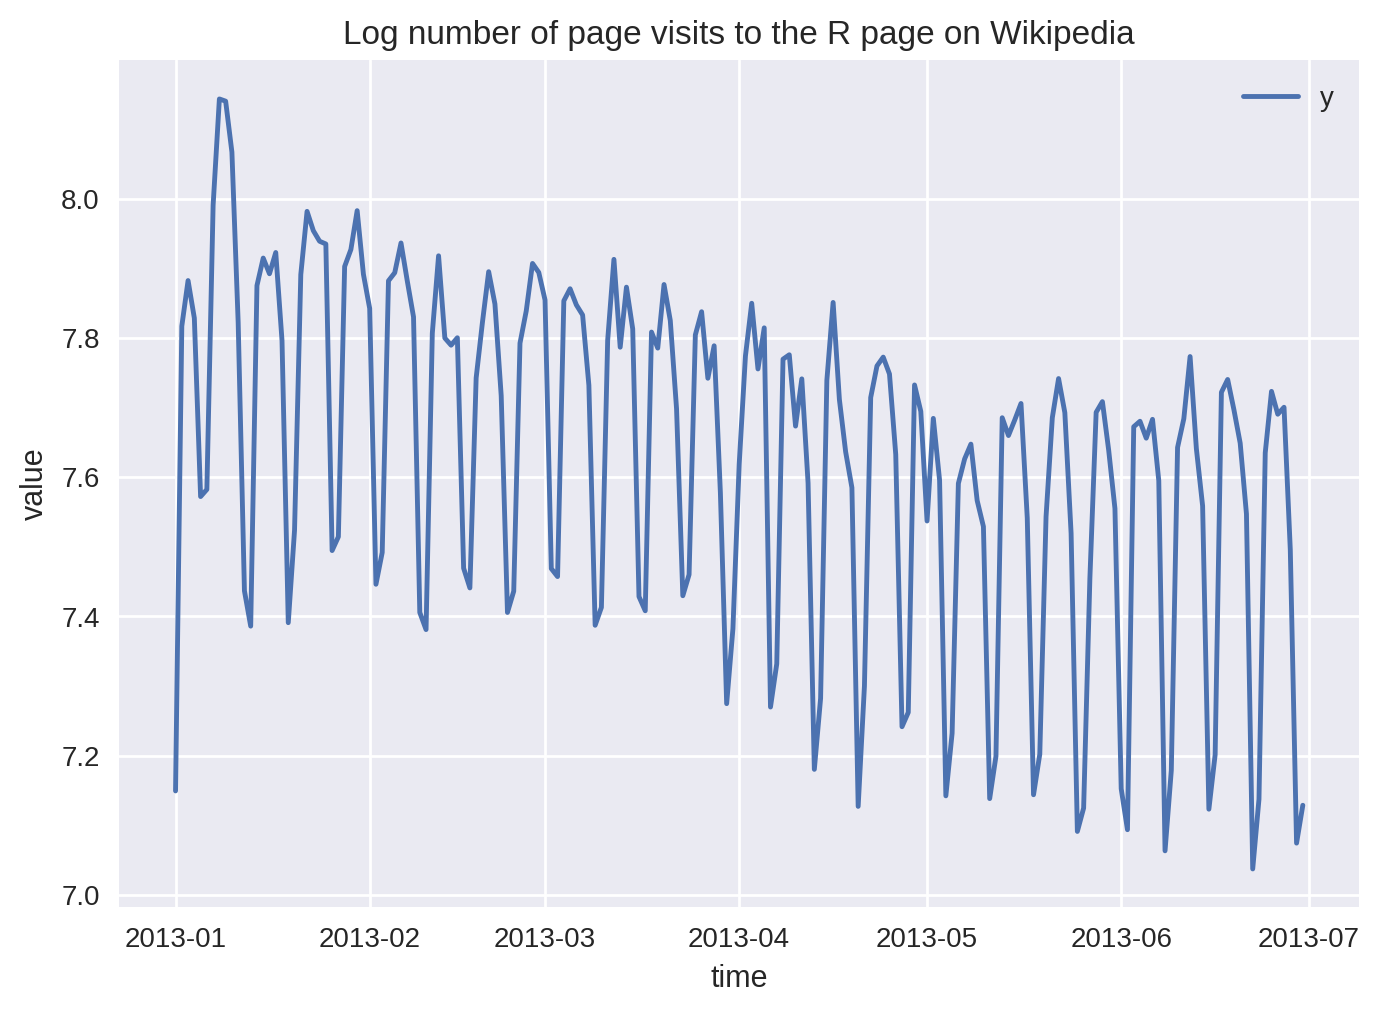

In [9]:
# let's plot the time series
df.plot(x='ds', y='y', kind='line')

# add labels & title
plt.xlabel('time')
plt.ylabel('value')
plt.title('Log number of page visits to the R page on Wikipedia');

In what follows, we first fit the Prophet model with historical data and then make predictions for the next 15 days.

In [10]:
import pandas as pd
from prophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

##############################################
# select the variable to forecast
df = df[["ds", "y"]]

##############################################
# define the model
model = Prophet()

##############################################
# fit the model on historical data
model.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwc9tbcd5/ei5v0fqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwc9tbcd5/1fjvzkj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36498', 'data', 'file=/tmp/tmpwc9tbcd5/ei5v0fqp.json', 'init=/tmp/tmpwc9tbcd5/1fjvzkj_.json', 'output', 'file=/tmp/tmpwc9tbcd5/prophet_modelbnpiy9ev/prophet_model-20230417071757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:17:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:17:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
##############################################
# Define the future forecast horizon
num_periods = 15

##############################################
# Create a dataframe for the future forecast
future = model.make_future_dataframe(periods=num_periods)

##############################################
# Create the future forecast dataframe, 
# which holds the history and the future predictions
forecast = model.predict(future)

In [12]:
forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,7.7370,7.7774,7.9959,7.7370,7.7370,0.1501,0.1501,0.1501,0.1501,0.1501,0.1501,0.0000,0.0000,0.0000,7.8872
1,2013-01-02,7.7406,7.8045,8.0108,7.7406,7.7406,0.1658,0.1658,0.1658,0.1658,0.1658,0.1658,0.0000,0.0000,0.0000,7.9064
2,2013-01-03,7.7441,7.7923,7.9982,7.7441,7.7441,0.1502,0.1502,0.1502,0.1502,0.1502,0.1502,0.0000,0.0000,0.0000,7.8943
3,2013-01-04,7.7477,7.6962,7.9147,7.7477,7.7477,0.0564,0.0564,0.0564,0.0564,0.0564,0.0564,0.0000,0.0000,0.0000,7.8040
4,2013-01-05,7.7512,7.3057,7.5116,7.7512,7.7512,-0.3428,-0.3428,-0.3428,-0.3428,-0.3428,-0.3428,0.0000,0.0000,0.0000,7.4085


In [13]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
191,2013-07-11,7.4888,7.5392,7.7584,7.4845,7.4936,0.1502,0.1502,0.1502,0.1502,0.1502,0.1502,0.0000,0.0000,0.0000,7.6389
192,2013-07-12,7.4886,7.4317,7.6453,7.4837,7.4942,0.0564,0.0564,0.0564,0.0564,0.0564,0.0564,0.0000,0.0000,0.0000,7.5449
193,2013-07-13,7.4884,7.0407,7.2563,7.4828,7.4947,-0.3428,-0.3428,-0.3428,-0.3428,-0.3428,-0.3428,0.0000,0.0000,0.0000,7.1456
194,2013-07-14,7.4882,7.0891,7.3055,7.4818,7.4957,-0.2968,-0.2968,-0.2968,-0.2968,-0.2968,-0.2968,0.0000,0.0000,0.0000,7.1913
195,2013-07-15,7.4880,7.4990,7.7122,7.4809,7.4965,0.1171,0.1171,0.1171,0.1171,0.1171,0.1171,0.0000,0.0000,0.0000,7.6050


Let's have a look at the last 10 predictions made by our forecasting model. We will take the inverse of the log by an `exp()` transformation to get the actual values of the predicted number of daily page visits. Let's also get the day of the week for each one of these periods.

In [14]:
prediction_summary = forecast[["ds", "yhat"]][-10:]

###
prediction_summary['yhat_actual'] = np.round(np.exp(prediction_summary['yhat']), 0)
prediction_summary['yhat_actual'] = prediction_summary['yhat_actual'].astype(int)

###
prediction_summary['dayofweek'] = pd.DatetimeIndex(prediction_summary['ds']).day_name()


###
prediction_summary

,ds,yhat,yhat_actual,dayofweek
186,2013-07-06,7.1470,1270,Saturday
187,2013-07-07,7.1927,1330,Sunday
188,2013-07-08,7.6064,2011,Monday
189,2013-07-09,7.6393,2078,Tuesday
190,2013-07-10,7.6548,2111,Wednesday
191,2013-07-11,7.6389,2078,Thursday
192,2013-07-12,7.5449,1891,Friday
193,2013-07-13,7.1456,1269,Saturday
194,2013-07-14,7.1913,1328,Sunday
195,2013-07-15,7.6050,2008,Monday


### Model Visualisation

We can also plot the historical model fit together with the future predictions including the confindence intervals.

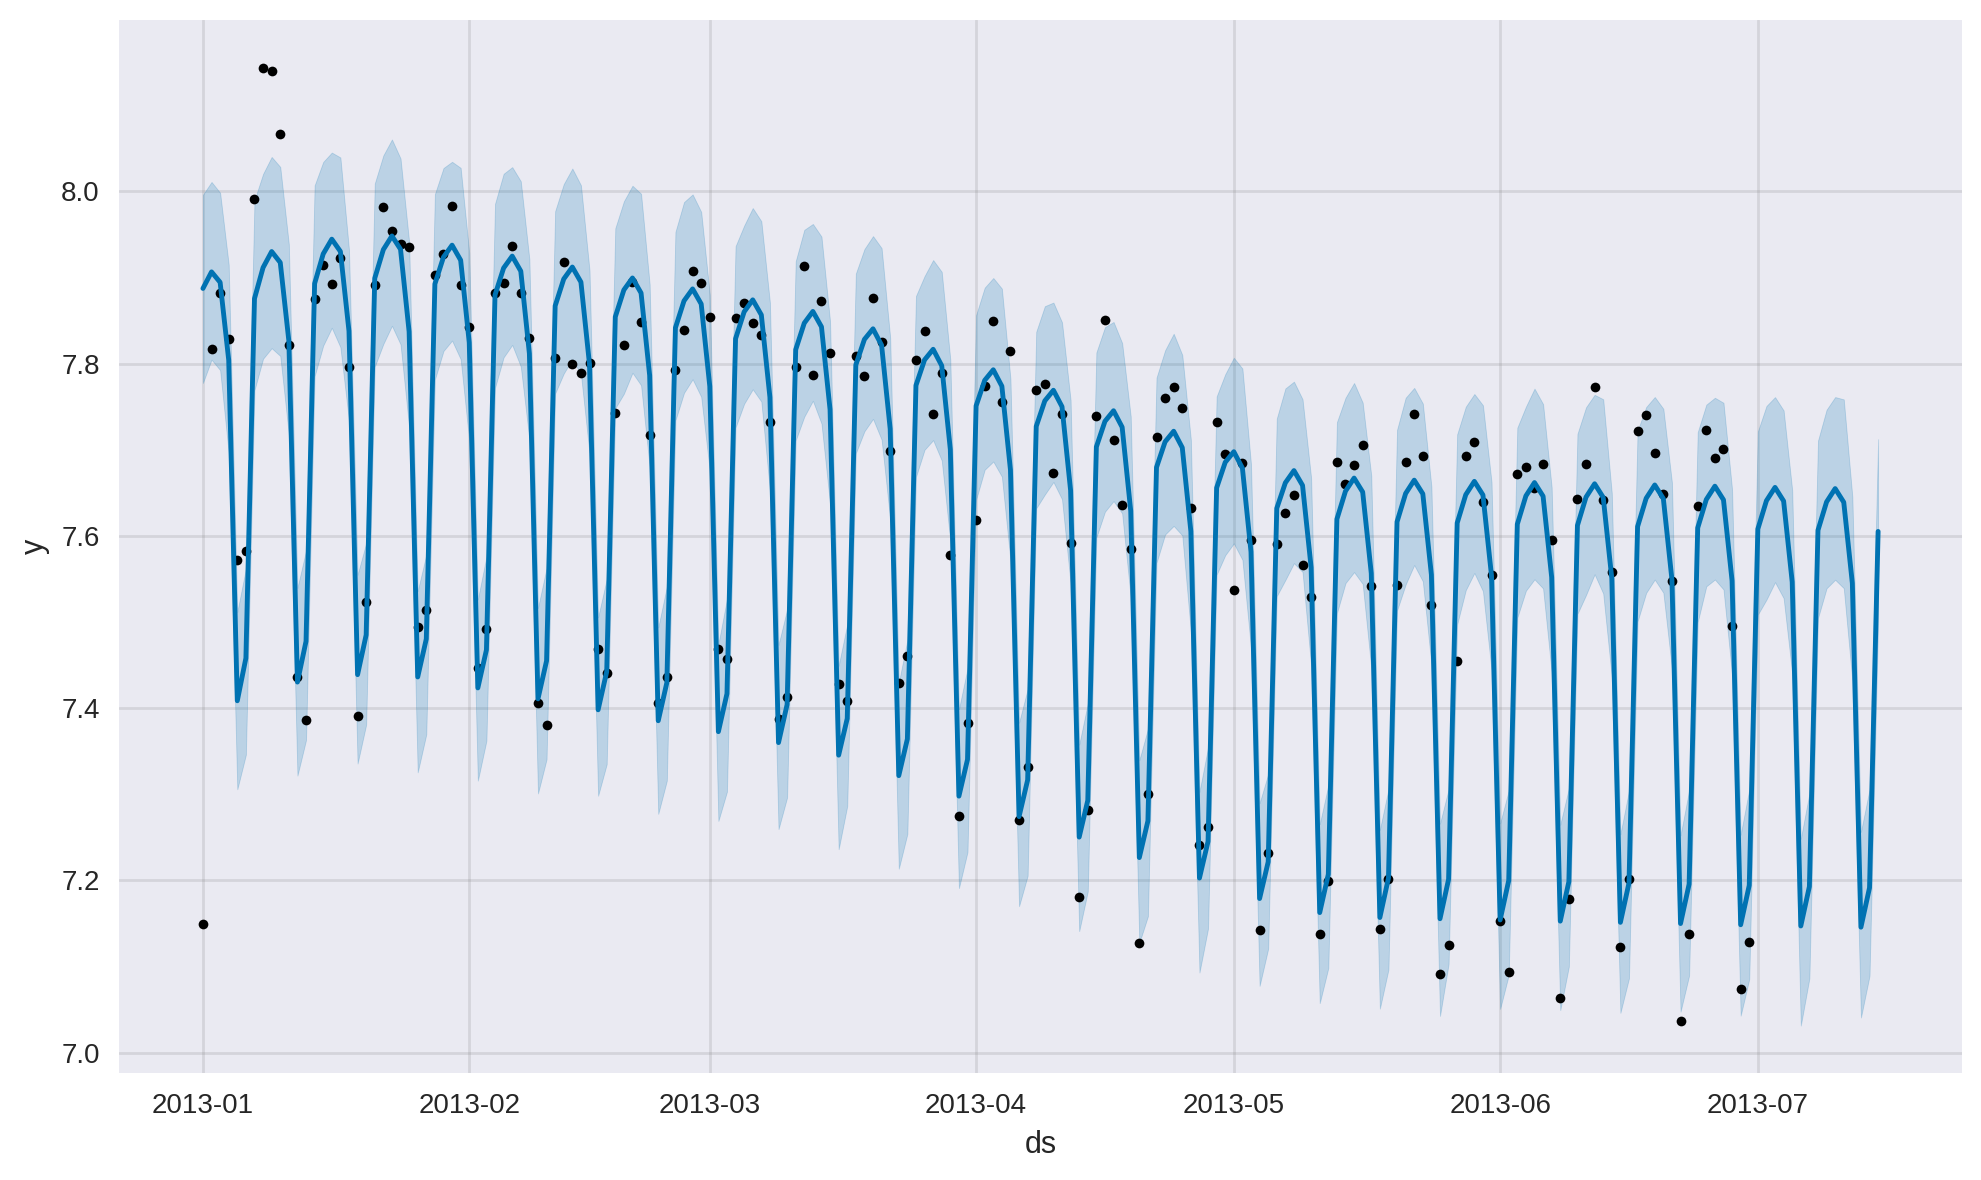

In [15]:
fig1 = model.plot(forecast)

### Time Series Change Points

Change points in a time series are when the trend of the time series changes, such as a new product launch or a new competitor entering the market. In Prophet, we can either let the model automatically try to estimate the change points or we can define them manually ourselves. In what follows, the change points are estimated automatically and overlayed on the same plot as red vertical bars.

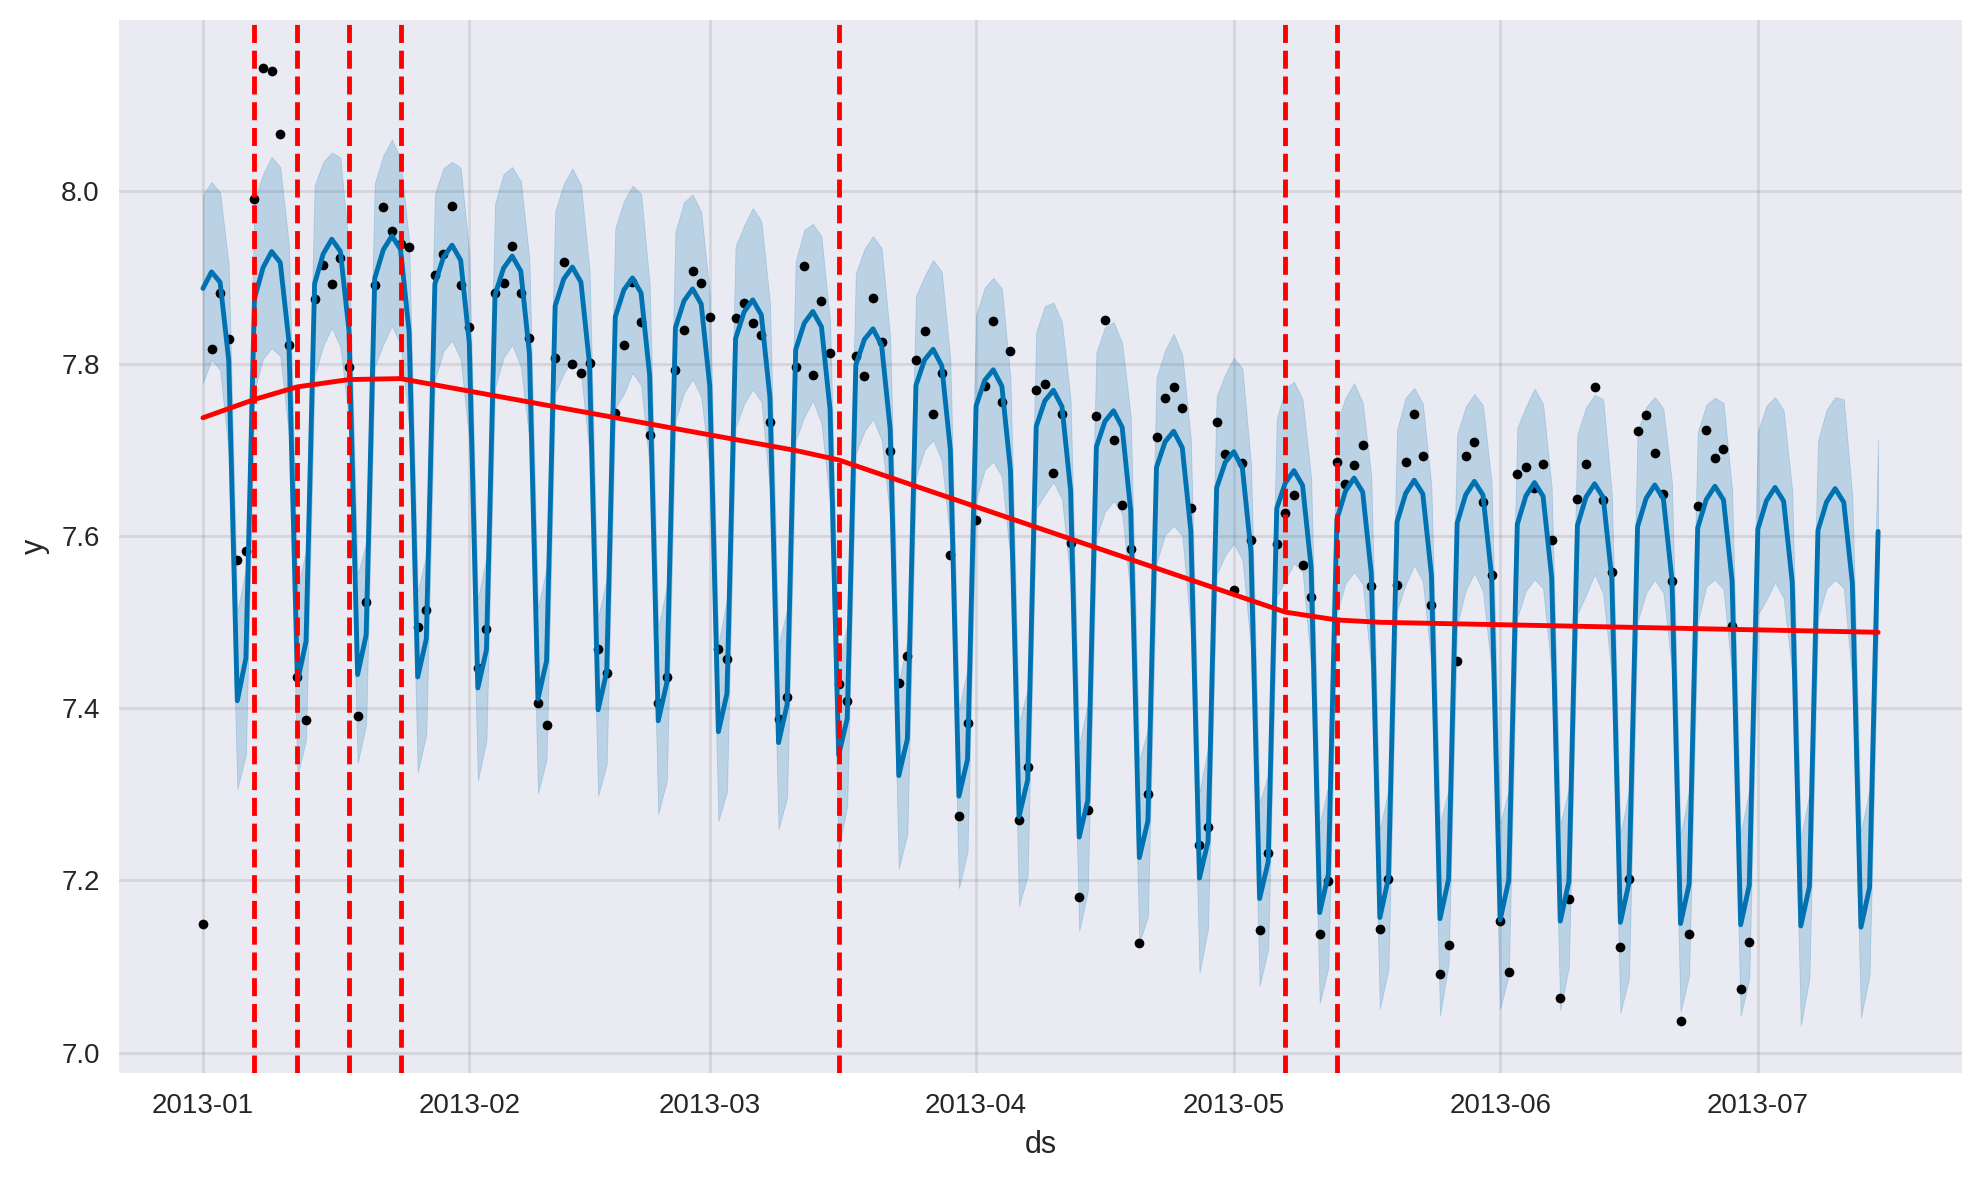

In [16]:
from prophet.plot import add_changepoints_to_plot

a = add_changepoints_to_plot(fig1.gca(), model, forecast)

fig1

By default, Prophet will try to automatically detect the trend change points. However, we can control this process via input parameters (that is, hyperparameters) if Prophet misses a trend change or if it is overfitting or underfitting.

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), we can adjust the strength of the sparse prior using the input parameter `changepoint_prior_scale`:
```Python
model = Prophet(changepoint_prior_scale=0.05)
```
By default, this parameter is set to 0.05. Increasing it will make the trend more flexible (more change points) and decreasing it will make the trend less flexible (less change points). For instance, for our case study, setting this parameter to 0.02 results in 3 estimated historical change points whereas the default value results in 7 estimated change points.

Rather than using automatic change point detection, we can manually specify the locations of potential change points with the `changepoints` argument. Slope changes will then be allowed only at these points. The change points can be limited to a small set of dates as below:
```Python
model = Prophet(changepoints=['2013-01-15', '2013-03-23'])
```

**Reference:** 
- https://facebook.github.io/prophet/docs/trend_changepoints.html

### Time Series Decomposition

We can decompose the time series into its components as below using the model's `plot_components()` method.

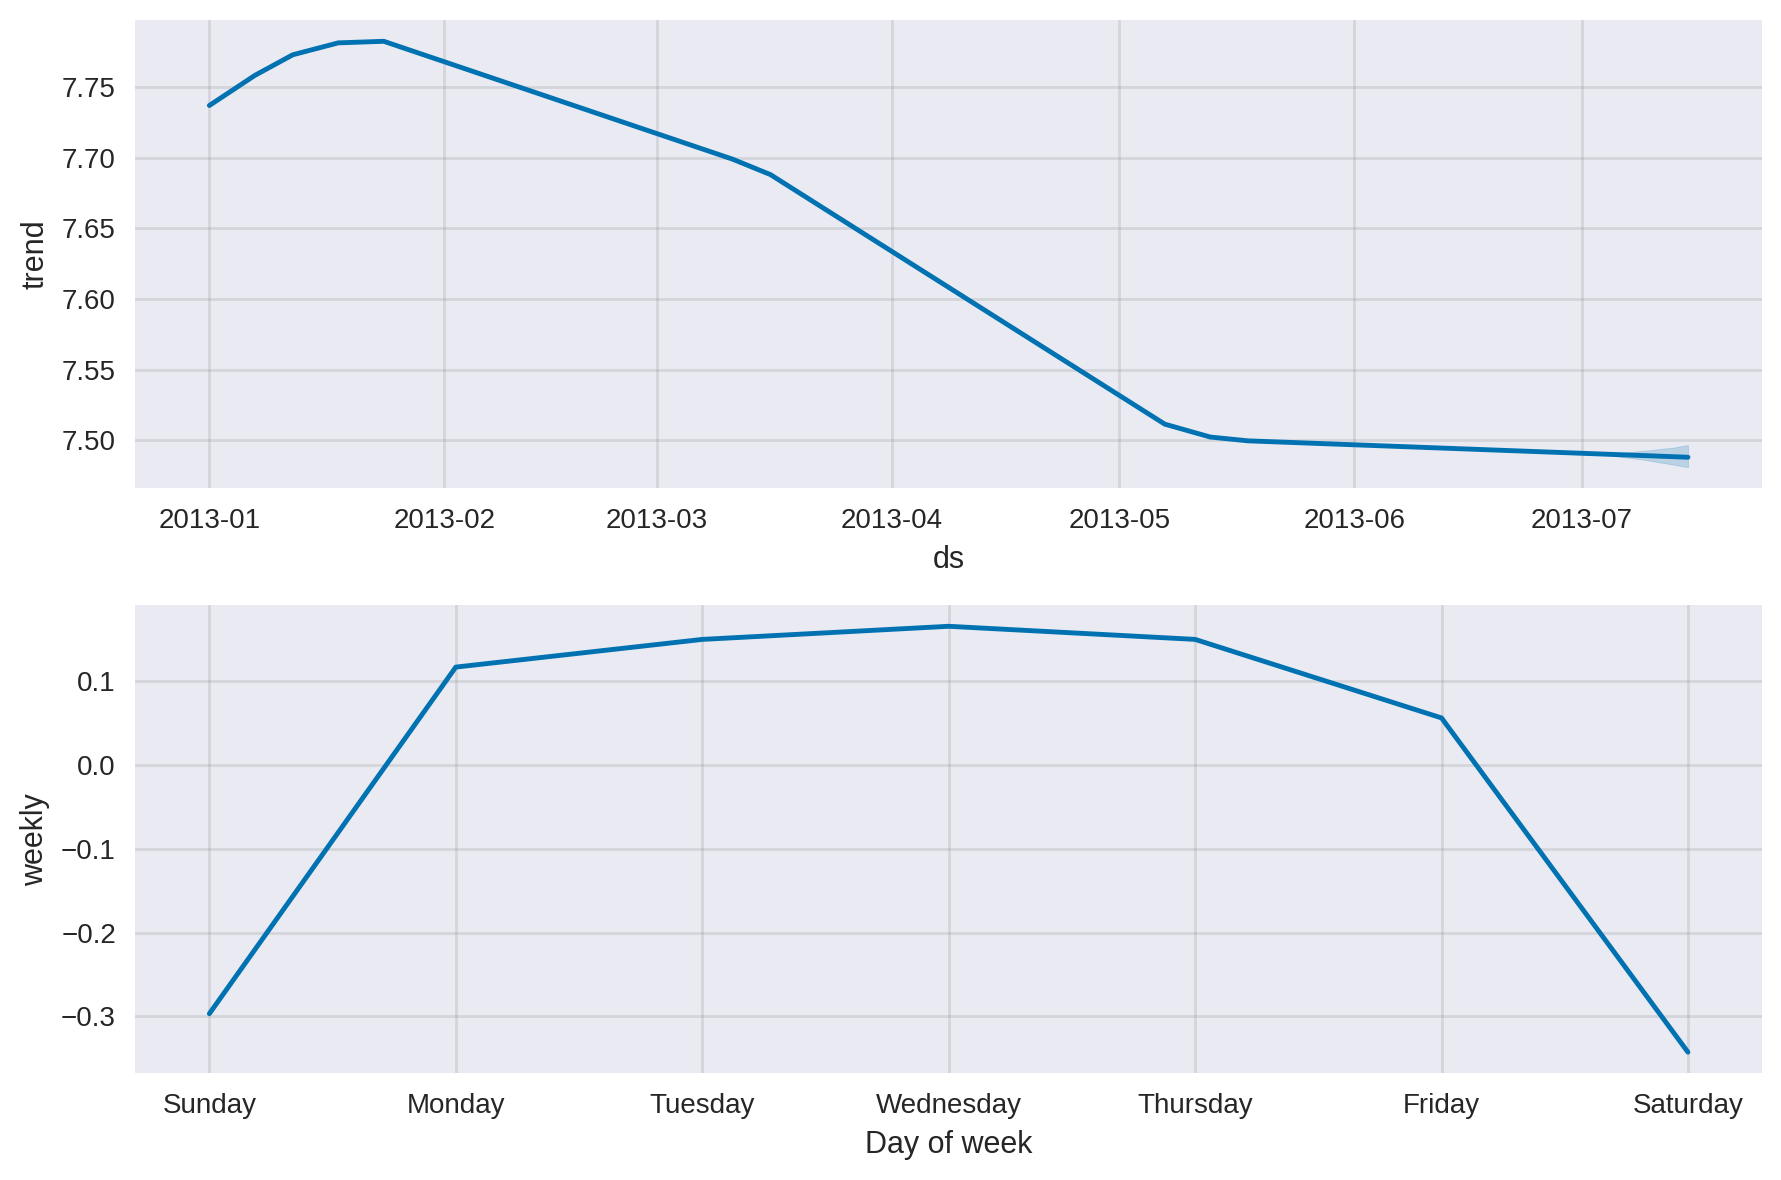

In [17]:
fig2 = model.plot_components(forecast)

### Interactive Model Visualisation

We can visualise the model & its components in an interactive manner as below. 

Please note that unfortunately GitHub does not currently support interactive `plotly` plots, so you will need to open this notebook with a Jupyter notebook environment for the interactions to work. 

In [18]:
# need to have the plotly module installed for the following to work

from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [19]:
plot_components_plotly(model, forecast)

### Multiplicative Seasonality

As mentioned earlier, the seasonality component of a time series represents any variation in its value that follows a consistent pattern over consecutive, fixed-length intervals. This variation may be modeled as a relatively constant amount independent of the time series' level (additive seasonality), or as a relatively constant proportion of the level (multiplicative seasonality).

By default, Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. However, in some cases, the seasonality needs to be modelled as multiplicative. Please see the link [here](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) for a time series example concerning the number of airline passengers where additive seasonality does not work and multiplicative seasonality is required. 

This can be achieved by passing in an additional model parameter as follows:
```Python
model = Prophet(seasonality_mode='multiplicative')
# or
model = Prophet(seasonality_mode='additive')  # this is the default parameter value
```

### Modelling Saturating Forecasts with Logistic Growth

In many forecasting scenarios, there is a natural upper bound (and maybe also a lower bound) such as the maximum number of available houses that can be sold etc. These are called *saturating forecasts*. Prophet allows us to make saturating forecasts using a *logistic growth trend model* with a specified carrying capacity. Here, we need to specify the carrying capacity in a column called *cap*. Optionally, we can also set a lower bound on the forecasts in a column called *floor*. Below is an example.

Reference: https://facebook.github.io/prophet/docs/saturating_forecasts.html

In [20]:
# define the model with the logistic growth parameter
model = Prophet(growth='logistic')

# set the upper limit "cap" 
# we can optionally set a lower limit "floor" if needed
#
# note that these limits don't have to be constant, that is,
# they can be set to different values at different times
upper_limit = 8
lower_limit = 7
df['cap'] = upper_limit
df['floor'] = lower_limit

# fit the model on historical data
model.fit(df)

# create a dataframe for the forecast
future = model.make_future_dataframe(periods=num_periods)

##############################################

# we will need to set these limits again on the future data points
future['cap'] = upper_limit
future['floor'] = lower_limit

# create the forecast dataframe
forecast = model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwc9tbcd5/0io71x_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwc9tbcd5/urcnzrph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99572', 'data', 'file=/tmp/tmpwc9tbcd5/0io71x_w.json', 'init=/tmp/tmpwc9tbcd5/urcnzrph.json', 'output', 'file=/tmp/tmpwc9tbcd5/prophet_modelykeem341/prophet_model-20230417071800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:18:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:18:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


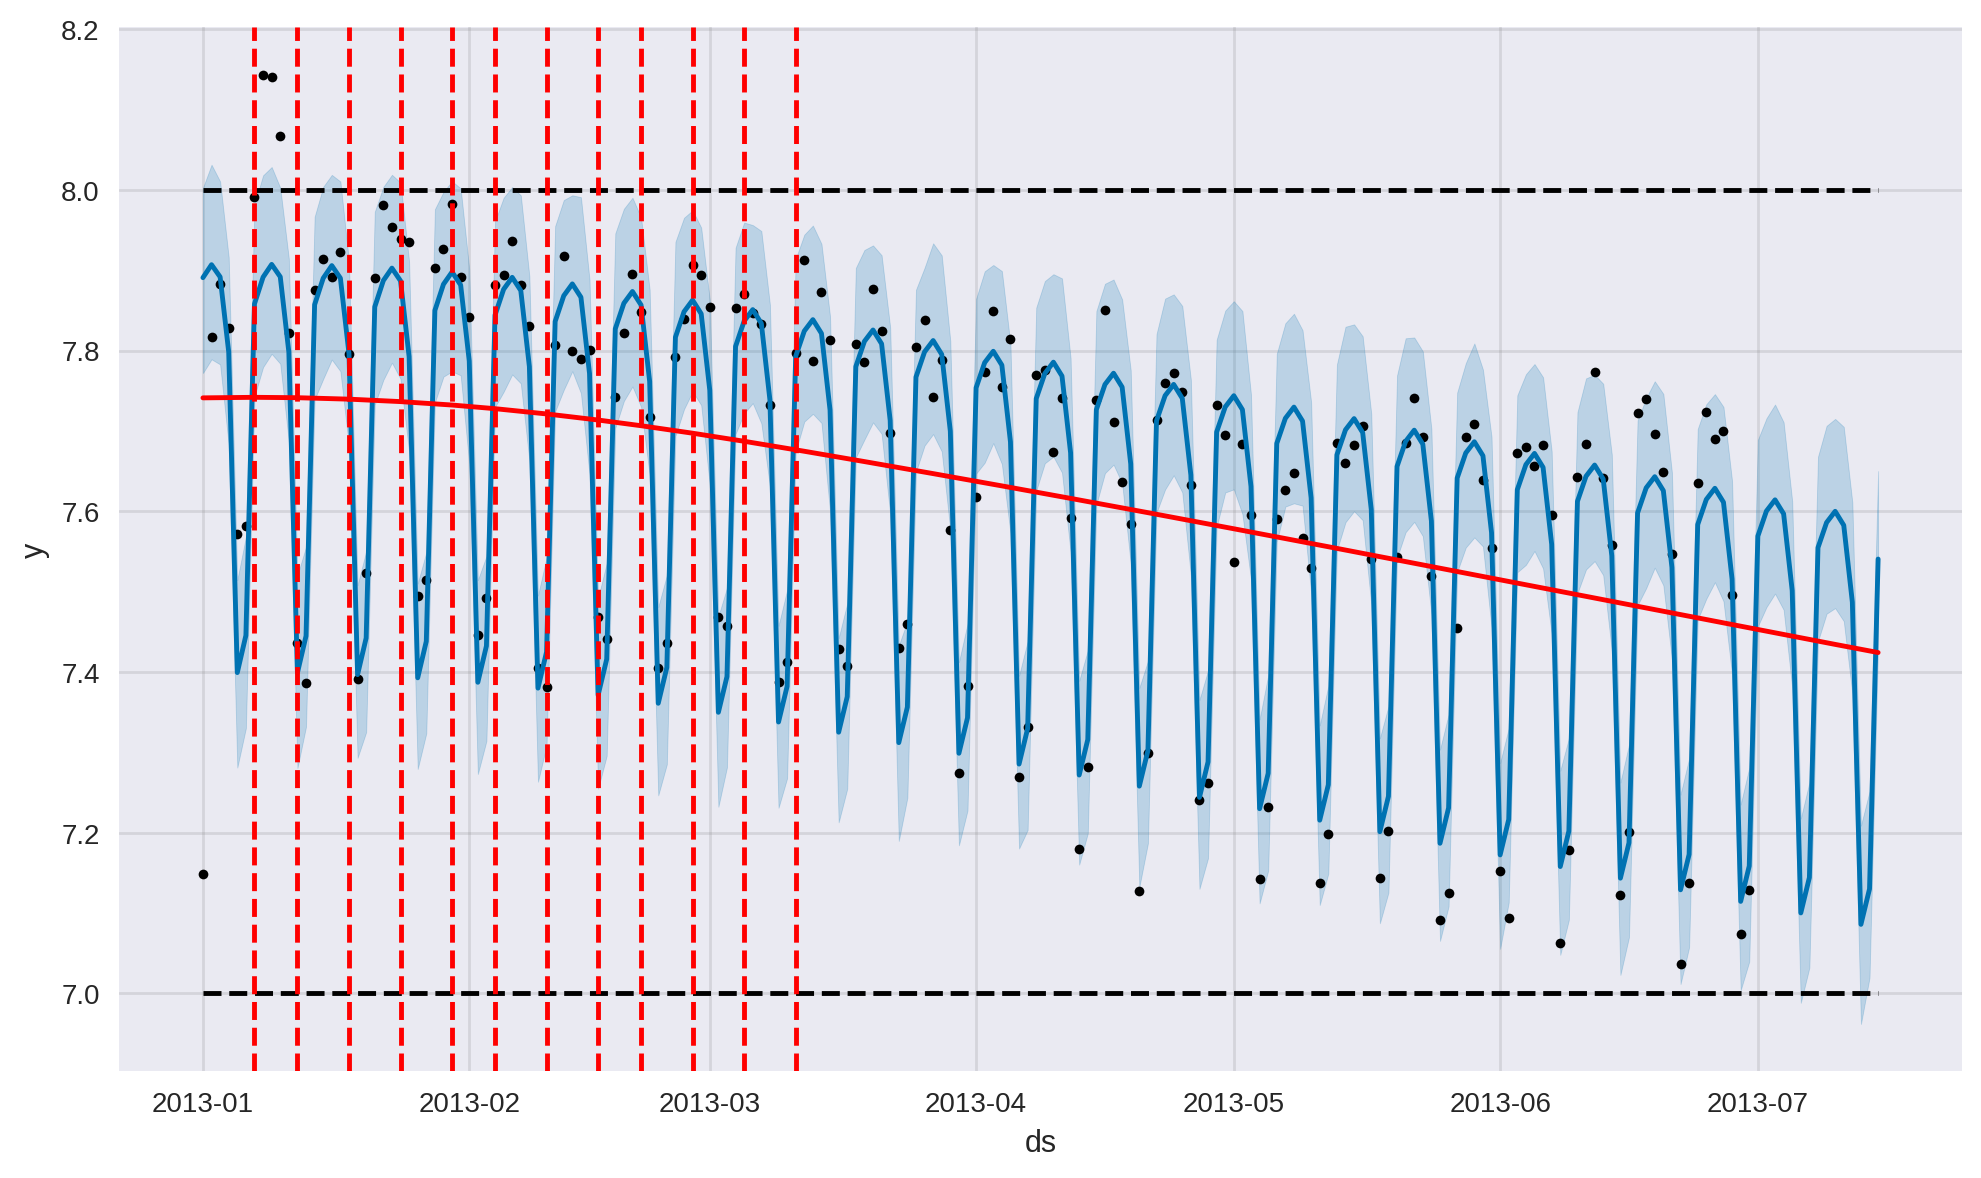

In [21]:
fig2 = model.plot(forecast)
a = add_changepoints_to_plot(fig2.gca(), model, forecast)

## Forecasting Model Evaluation <a id='me'></a>


### Tunable Parameters

The Prophet model has a number of input parameters that we might tune to improve model performance. Parameters that can be tuned are as follows:

- **changepoint_prior_scale:** This parameter determines the flexibility of the trend, and in particular how much the trend changes at the trend change points and it is probably the most impactful parameter. If it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit. The default of **0.05** works fine for many time series, but this could be tuned. A tuning range of [0.001, 0.5] is recommended. 

- **seasonality_prior_scale:** This parameter controls the flexibility of the seasonality. A large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default value is **10**, which usually works fine as we rarely see overfitting here (since seasonality is already modelled as truncated Fourier series). A reasonable range for tuning this parameter is [0.01, 10]. For instance, when set to 0.01, the magnitude of seasonality will be forced to be very small.

- **seasonality_mode:** Options are `additive` and `multiplicative`. Default is additive, but many real-world time series will have multiplicative seasonality. This is best identified by visualising the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series.

### Cross-validation

We can use cross validation to measure model performance using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We will also need to define the length of the training period (via the `initial` parameter) and the length of the test period (via the `horizon` parameter). Suppose we have the following parameter values for our case study:

```Python
cutoffs = pd.to_datetime(['2013-04-01', '2013-05-01'])
df_cv = cross_validation(model, 
                         cutoffs=cutoffs, 
                         initial='3 months', 
                         horizon='15 days', 
                         parallel="processes")
```
Since we have two cutoff dates in this case, we will be training & testing two models (more precisely, two *folds* within a cross-validation framework) using parallel processing as follows:
- One model (that is, one fold) trained on 3 months worth of data until April 1st and then tested on each one of the next 15 days.
- Another model (that is, one fold) trained on 3 months worth of data until May 1st and then tested on each one of the next 15 days.

### Performance Metrics

The `performance_metrics` method can be used to compute some useful statistics concerning the prediction performance (yhat, yhat_lower, and yhat_upper compared to y):
```Python
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
```

The statistics computed are as follows:
- mean squared error (MSE)
- root mean squared error (RMSE)
- mean absolute error (MAE)
- mean absolute percent error (MAPE)
- median absolute percent error (MDAPE)
- coverage rate of the yhat_lower and yhat_upper estimates

The `performance_metrics` method always averages over the available folds (i.e., cutoffs). With the `rolling_window` method parameter set to "1", model performance will be reported as single value that is the average performance across all the folds. Here, each fold performance will be the model's performance (such as RMSE) on the test data across the entire forecast horizon for that particular fold. As an example, for the scenario above with two folds with a horizon of 15 days, we would first compute the test RMSE value   across 15 days for each of the two folds, and then report the average of these two numbers as the overall model performance.

### Hyperparameter Tuning

Cross-validation can be used for tuning hyperparameters of the model, such as `changepoint_prior_scale` and `seasonality_prior_scale`. A Python example is given below with a 3x3 grid of these two parameters with parallelisation over cutoffs. Here, parameters are evaluated on test RMSE averaged over a 15-day horizon across 2 cut-off dates.

In [22]:
import itertools
import numpy as np
import pandas as pd

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = True
logger.setLevel(logging.CRITICAL)

param_grid = {  
    'changepoint_prior_scale': [0.005, 0.05, 0.5],  # default is 0.05
    'seasonality_prior_scale': [1.0, 10.0, 20],  # default is 10
    # 'seasonality_mode': ['multiplicative', 'additive'] # default is additive
}

cutoffs = pd.to_datetime(['2013-04-01', '2013-05-01'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmses = []  # Store the RMSEs for each params here
mdapes = []  # Store the Median absolute percent errors for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    ###
    m = Prophet(**params).fit(df)  # Fit model with given params
    ###
    df_cv = cross_validation(m, 
                         cutoffs=cutoffs, 
                         initial='3 months', 
                         horizon='15 days', 
                         parallel="processes")    
    ###
    df_p = performance_metrics(df_cv, rolling_window=1)
    ###
    rmses.append(df_p['rmse'].values[0])
    mdapes.append(df_p['mdape'].values[0])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc1d236ffd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc1d2355520>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc1d234abb0>
INFO:prophet:Disabling yearly seasonality. Run prophet 

Let's have a look at the results of the the tuning process and identify the best parameter combination with respect to RMSE.

In [23]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)

tuning_results['rmse'] = rmses
tuning_results['mdape'] = mdapes

tuning_results_sorted = tuning_results.sort_values(by='rmse', ascending=True)

print(tuning_results_sorted.to_string())

   changepoint_prior_scale  seasonality_prior_scale   rmse  mdape
5                   0.0500                  20.0000 0.0658 0.0049
3                   0.0500                   1.0000 0.0659 0.0049
4                   0.0500                  10.0000 0.0662 0.0052
1                   0.0050                  10.0000 0.0753 0.0072
2                   0.0050                  20.0000 0.0758 0.0072
0                   0.0050                   1.0000 0.0759 0.0072
6                   0.5000                   1.0000 0.0771 0.0049
7                   0.5000                  10.0000 0.0771 0.0049
8                   0.5000                  20.0000 0.0771 0.0049


In [24]:
best_params = all_params[np.argmin(rmses)]

print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20}


Below, we show the contents of `df_cv` and `df_p` for the best parameter combination.

In [25]:
m_opt = Prophet(changepoint_prior_scale = best_params['changepoint_prior_scale'], 
                seasonality_prior_scale = best_params['seasonality_prior_scale'])

m_opt.fit(df)  # Fit model with best params

df_cv_opt = cross_validation(m_opt, 
                     cutoffs=cutoffs, 
                     initial='3 months', 
                     horizon='15 days', 
                     parallel="processes")  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc1d22eeca0>


In [26]:
# 2 folds with horizon=15, df_cv_opt will have 30 rows

print(f"{df_cv_opt.shape = }")

df_cv_opt.shape = (30, 6)


In [27]:
df_cv_opt.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-04-02,7.7378,7.6306,7.8451,7.7740,2013-04-01
1,2013-04-03,7.7760,7.6757,7.8744,7.8497,2013-04-01
2,2013-04-04,7.7589,7.6574,7.8647,7.7553,2013-04-01
3,2013-04-05,7.6611,7.5544,7.7685,7.8144,2013-04-01
4,2013-04-06,7.2981,7.1995,7.4067,7.2696,2013-04-01


In [28]:
df_cv_opt.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
25,2013-05-12,7.2138,7.1094,7.3247,7.1989,2013-05-01
26,2013-05-13,7.6034,7.4914,7.7115,7.6852,2013-05-01
27,2013-05-14,7.6236,7.5103,7.7381,7.6596,2013-05-01
28,2013-05-15,7.6345,7.5187,7.7363,7.6820,2013-05-01
29,2013-05-16,7.6246,7.5121,7.7380,7.7057,2013-05-01


In [29]:
# this will be a data frame with only one row
df_p_opt = performance_metrics(df_cv_opt, rolling_window=1)

df_p_opt

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,15 days,0.0043,0.0658,0.0508,0.0067,0.0049,0.0067,0.9333


### Visualisation of Cross-Validation Results

Below, we plot the average RMSE values across the cross validation folds for each one of the 15 days within the forecasting horizon for the best paramater combination. We observe that RMSE is relatively stable except for towards the end of the horizon where RMSE increases significantly. 

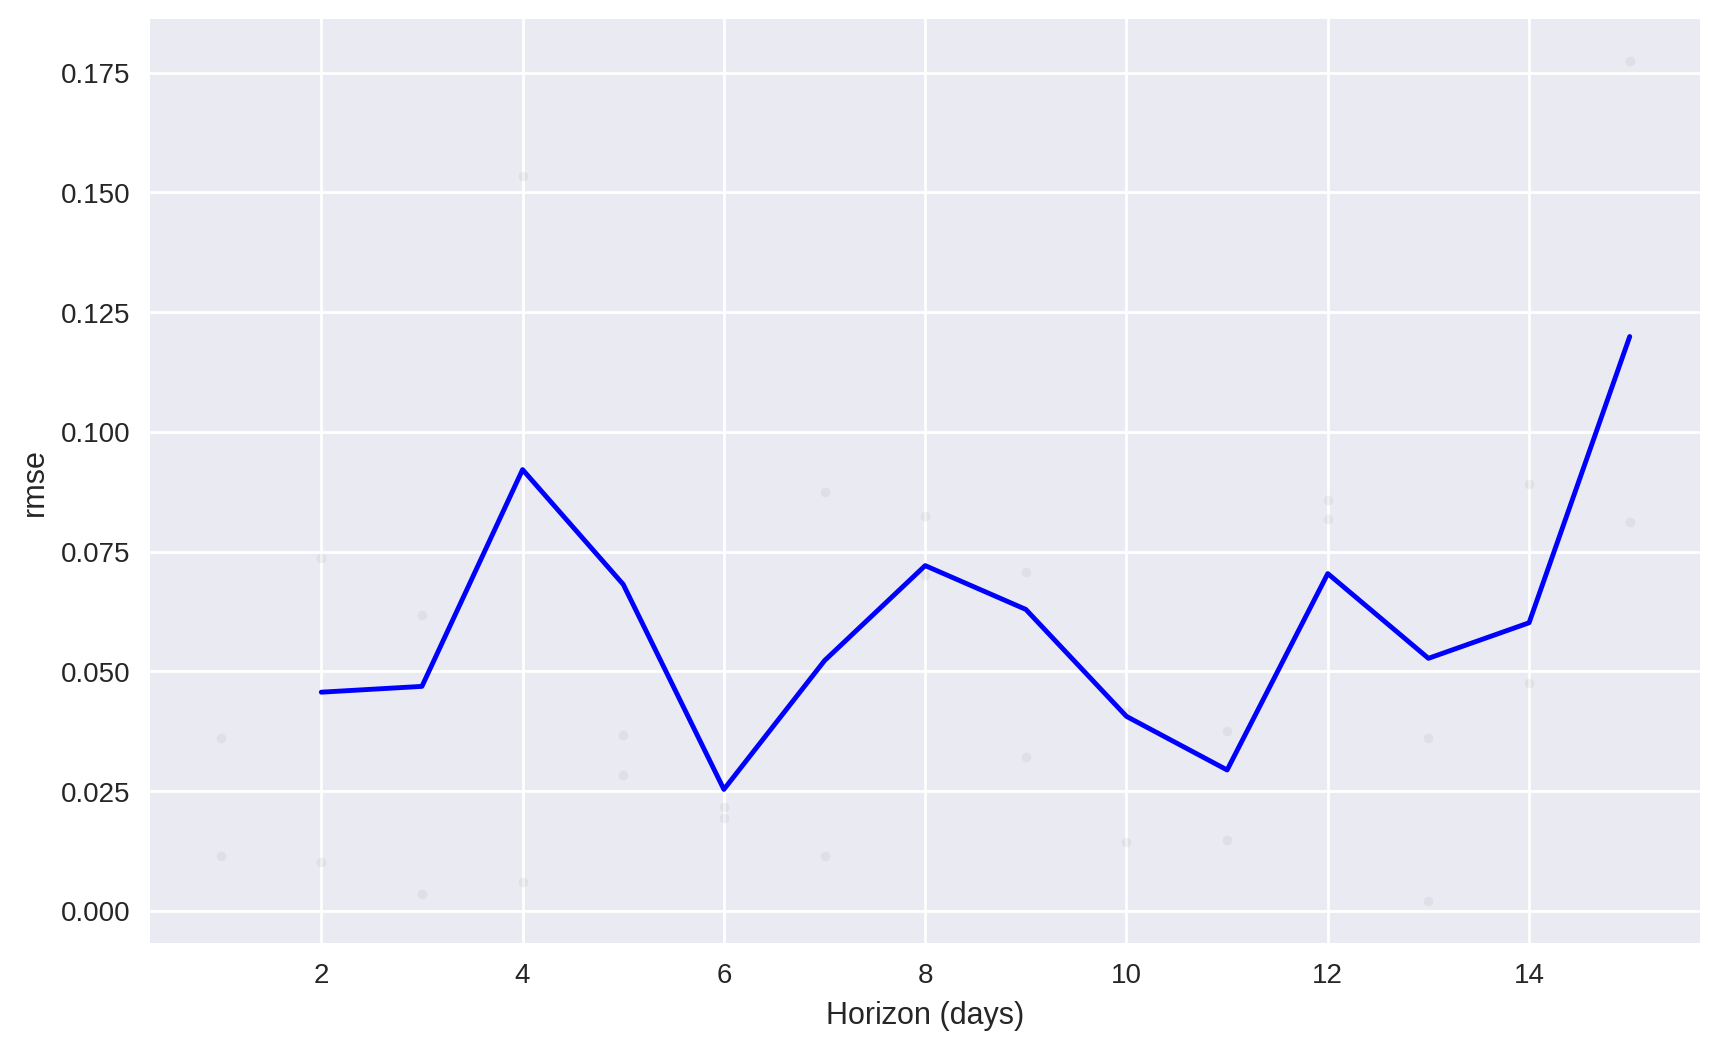

In [30]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv_opt, metric='rmse')

### Post Hyperparameter-Tuning

Once the tuning is completed, we notice that there is not a huge amount of difference between the parameter combinations, yet the best set of hyper-parameter values with respect to the RMSE metric are as follows:
- changepoint_prior_scale = 0.05
- seasonality_prior_scale = 20

Below we fit a new model with these optimal parameter values and produce a new future forecast.

In [31]:
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20}


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


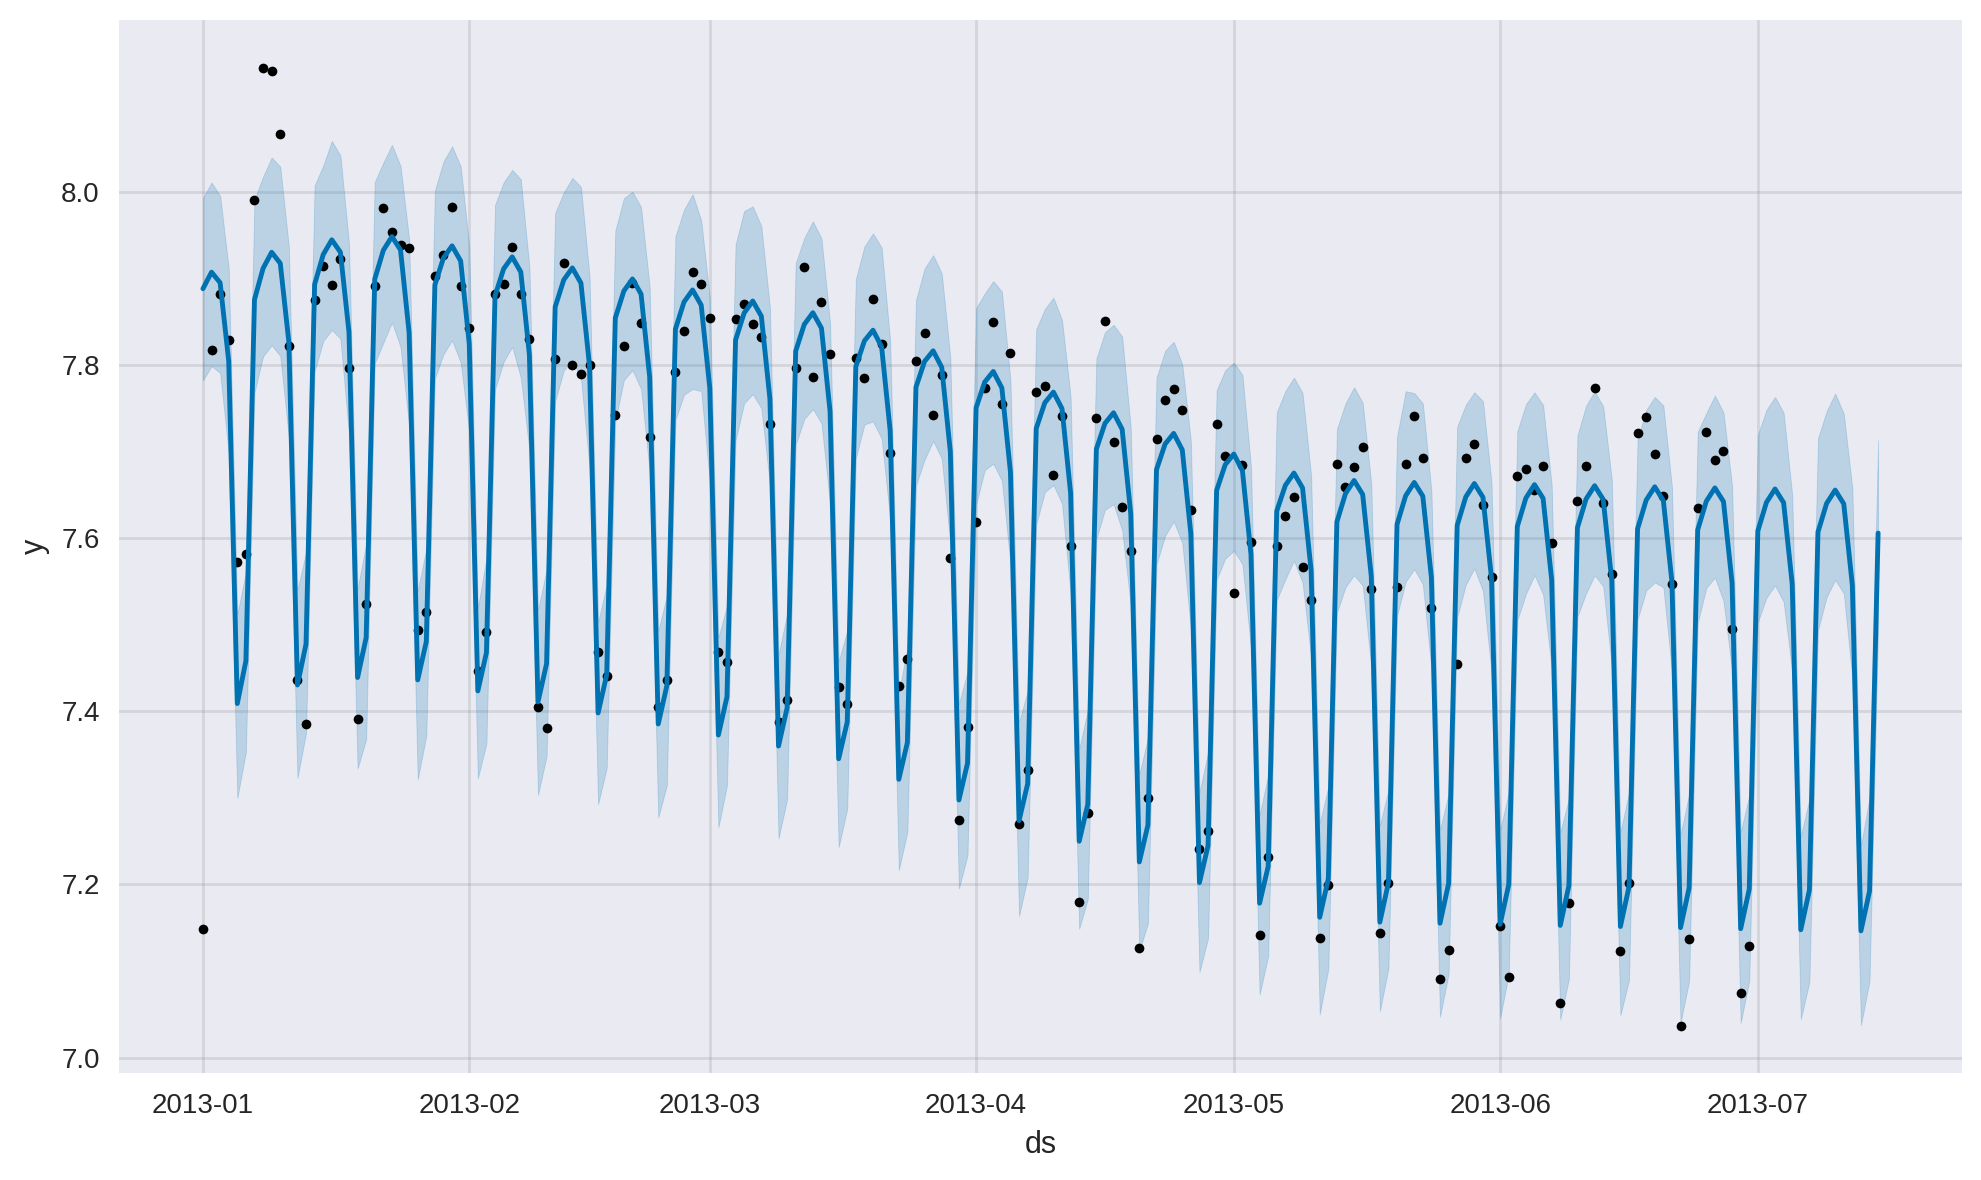

In [32]:
# define the model
model2 = Prophet(changepoint_prior_scale = best_params['changepoint_prior_scale'], 
                 seasonality_prior_scale = best_params['seasonality_prior_scale'])

##############################################
# fit the model on historical data
model2.fit(df)

##############################################
# Define the forecast horizon
num_periods = 15

##############################################
# Create a dataframe for the forecast
future2 = model2.make_future_dataframe(periods=num_periods)

##############################################
# Create the forecast dataframe, which has the history
# and the future predictions
forecast2 = model2.predict(future2)


##############################################
fig2 = model.plot(forecast2)

# a = add_changepoints_to_plot(fig2.gca(), model, forecast)

## Conclusion & Further References <a id='conc'></a>

Forecasting is as much an art as it is science and its technical aspects can become rather overwhelming even for individuals with a strong technical background. Luckily, the Prophet model automates this task for a large number of practical scenarios as it has relatively few input parameters and their default values work quite well in general. In addition to trend and seasonality, the Prophet model can also handle holidays and special events, though this is not covered in this tutorial for brevity.

Another popular family of models for forecasting is the ARIMA (auto-regressive, integrated moving average) and SARIMA (seasonal ARIMA) models. We do not cover these models in here as they they have more moving parts compared to the Prophet model and they usually require quite a bit of fine-tuning of their input parameters for satisfactory performance. 

A web-based platform for no-code, GUI-driven automated forecasting is Big ML: www.bigml.com. This platform can handle time series with both trend and seasonality (both additive and multiplicative) and uses the [Holt-Winters](https://otexts.com/fpp2/holt-winters.html) exponential-smoothing based forecasting algorithm behind the scenes. It allows for different performance metrics such as RMSE, AIC (Akaike information criterion), and BIC (Bayesian information criterion). The platform can fit a number of models automatically, find the best model with respect to a particular metric, and produce future forecasts through a nice, user-friendly graphical interface.


The interested reader is referred to the excellent open source book below for an accessible overview of theory and practice of forecasting:

- Forecasting: Principles and Practice (3rd ed): https://otexts.com/fpp3/

***